In [35]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

If the Dropbox folder is shared and on your C drive, changing user to your username should give file access.

In [4]:
user = 'Steve Hall'
os.chdir('C:/Users/' + user + '/Dropbox/Projects/ULE Growth/')
filePath = 'C:/Users/' + user + '/Dropbox/Projects/ULE Growth/'

In [11]:
gdf = gpd.read_file(filePath + 'Final Dataset/ULE/ULE.shp')
ule = gdf[['GEOID','NAME','Year','GMP','Population','Area']]

In [13]:
print(ule.shape)
print(ule.head())

(3700, 6)
   GEOID          NAME  Year         GMP  Population        Area
0  10100  Aberdeen, SD  2001   3101395.0     81191.0   16.274849
1  10140  Aberdeen, WA  2001  15379048.0    447025.0    0.936891
2  10180   Abilene, TX  2001   8064415.0    265524.0  106.347590
3  10220       Ada, OK  2001   5656851.0    223737.0    5.695775
4  10300    Adrian, MI  2001  58443937.0   1279512.0   14.633214


GMP is real gross metropolitan product in 2012 chained dollars.  Area is in square kilometers.  Area data from 2000 is used as a proxy for 2001.

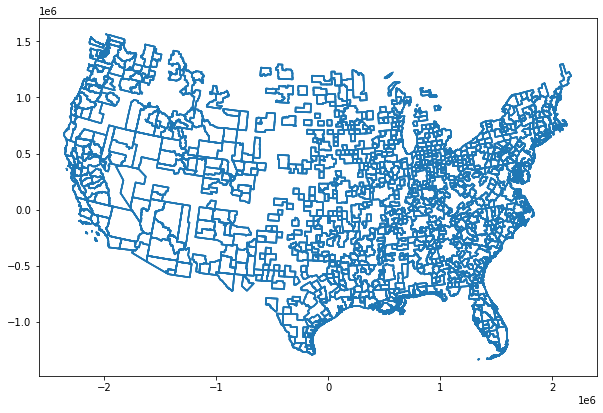

In [36]:
gdf.boundary.plot(figsize=(10,10))

In [28]:
gdf2016 = gdf['Year']==2016
ule2016 = gdf[gdf2016]
print(ule2016.shape)
gdf2001 = gdf['Year']==2001
ule2001 = gdf[gdf2001]
print(ule2001.shape)

(925, 16)
(925, 16)


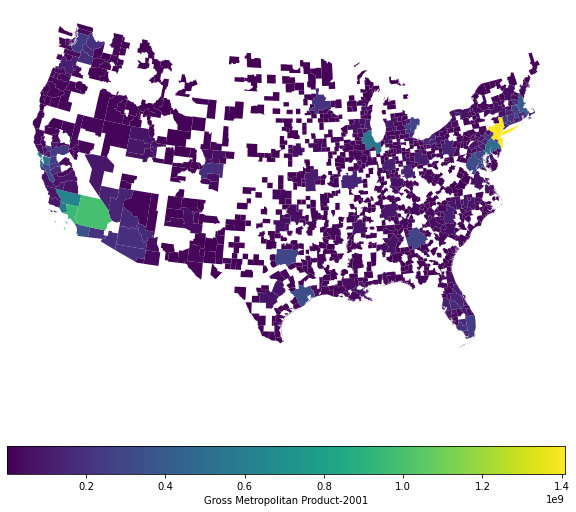

In [29]:
ax = ule2001.plot(figsize=(10,10), column='GMP', legend = True,legend_kwds={"label":"Gross Metropolitan Product-2001", "orientation":"horizontal"})
ax.set_axis_off()

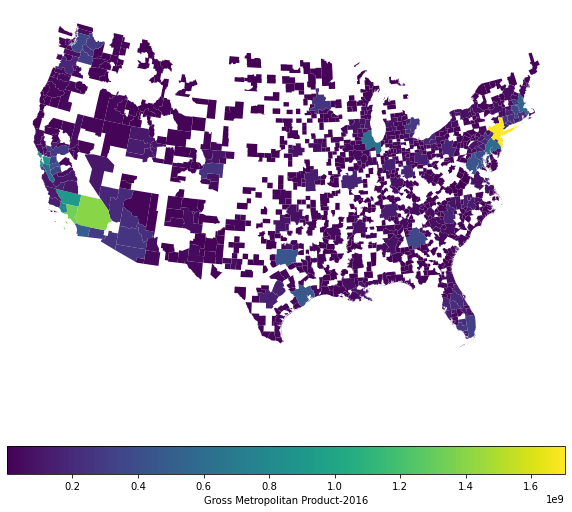

In [34]:
ax1 = ule2016.plot(figsize=(10,10), column='GMP',legend = True,legend_kwds={"label":"Gross Metropolitan Product-2016", "orientation":"horizontal"})
ax1.set_axis_off()